### This file is to calculate the confidence interval of the 4 moments

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import powerlaw
import psycopg2



In [2]:
def fitDist(distributions,data):
    df_fit = pd.DataFrame(columns=['dist','parms','loglik']) # dataframe to hold fitting results
    # fit distributions
    for dist in distributions:
        print(dist)
        parms = dist.fit(data)
        loglik = dist.nnlf(parms,data)
        # add fitting results to the dataframe
        result = pd.DataFrame([dist.name,parms,loglik]).T
        result.columns = df_fit.columns
        df_fit = pd.concat([df_fit,result],ignore_index=True)
    return df_fit

In [39]:
distributions_to_test=[stats.expon,stats.norm,stats.logistic,stats.t,stats.chi2,
                 stats.dweibull,stats.beta,stats.lognorm,stats.gamma,stats.skewnorm,stats.f,stats.powerlaw,stats.pareto]
def pipeline_(data,distribution=distributions_to_test,Bootstrap=True,tail_analysis=True):
    if Bootstrap:
        iteration = 5000

        len_=len(data)
        mean=[]
        var=[]
        skew=[]
        kurto=[]

        for i in range( iteration ):
            samp=np.random.choice(data,len_,replace=True)
            mean.append(np.mean(samp))
            var.append(np.var(samp))
            skew.append(stats.skew(samp))
            kurto.append(stats.kurtosis(samp))
        figure,[a,b,c,d]=plt.subplots(1, 4,figsize=(15,5))
        a.hist(mean,1000,label='mean')
        a.set_xlabel("mean")
        b.hist(var,1000,label='variance',color='r')
        b.set_xlabel("variance")
        c.hist(skew,1000,label='skew',color='y')
        c.set_xlabel("skew")
        d.hist(kurto,1000,label='kurtosis',color='g')
        d.set_xlabel("kurtosis")
        plt.show()
        print("confidence interval for the mean:[%6.4f - %6.4f]" % (np.percentile(mean,2.5),np.percentile(mean,97.5)))
        print("confidence interval for the variance:[%6.4f - %6.4f]" % (np.percentile(var,2.5),np.percentile(var,97.5)))
        print("confidence interval for the skew:[%6.4f - %6.4f]" % (np.percentile(skew,2.5),np.percentile(skew,97.5)))
        print("confidence interval for the kurtosis:[%6.4f - %6.4f]" % (np.percentile(kurto,2.5),np.percentile(kurto,97.5)))
       
    if tail_analysis:
        x=np.asarray(range(1,len(data)+1))
        f=lambda x:1-x/(len(data)+1)
        plt.loglog(np.sort(data),f(x),"x")
        np.seterr(divide='ignore', invalid='ignore')
        fit = powerlaw.Fit(data)
        tail_split,alpha=fit.xmin,fit.power_law.alpha
        print("Tail split at {}, alpha_value = {}".format(tail_split,alpha))
        tail=data[data>tail_split]
        body=data[data<data]
        x_=np.asarray(range(1,len(tail)+1))
        f=lambda x:1-x/(len(tail)+1)
        Fit=fit.power_law.plot_ccdf(color='r', linewidth=2,label="tail_fit")
        Fit.loglog(np.sort(tail),f(x_),'x',label="tail_data")
        plt.legend()
        plt.show()
        res=fitDist(distribution,data)
        #true_=res.sort_values(by='loglik',ascending=True).loc[0]
        
        #print("best dist is {}, with parameter {} ".format(true_.dist,true_.parms))
        return res,fit

        
        
        

In [0]:
#this part is to use Juhao's data. If use mine, do not run this code...
cleaned_data=pd.read_csv("cleaned_data.csv") # cleaned data based on junhao_CSGO + time spent playing

In [6]:
# Connect to database and select csgo.profiles
conn = psycopg2.connect("dbname='dreamteam' user='weisihan' host='localhost' port='5432' password='weisi9527sj'")
cur = conn.cursor()
# load csgo.profiles
cur.execute('SELECT * FROM csgo.profiles')
colnames = [desc[0] for desc in cur.description]
csgo_profiles = cur.fetchall()
cur.close()
conn.close()

In [7]:
csgo_profiles = pd.DataFrame(csgo_profiles, columns = colnames)
# data shape
print("data shape:",csgo_profiles.shape)
print("No. of users:",csgo_profiles['user_id'].count())
print()
# print columns
print("There are",csgo_profiles.shape[1],"columns:")
print(colnames)
csgo_profiles.head()

data shape: (84393, 17)
No. of users: 84393

There are 17 columns:
['user_id', 'nickname', 'total_kills', 'total_deaths', 'total_time_played', 'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins', 'total_rounds_played', 'total_shots_fired', 'rank_id', 'goal_id', 'steam_id', 'about', 'updated_at', 'compensation']


,user_id,nickname,total_kills,total_deaths,total_time_played,total_kills_headshot,total_shots_hit,total_mvps,total_wins,total_rounds_played,total_shots_fired,rank_id,goal_id,steam_id,about,updated_at,compensation
0,1,s1rc0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,None,NaT,NaN
1,5,rabbitshu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,None,NaT,NaN
2,3,Mochojojo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN,None,NaT,NaN
3,206,BoyKot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,7.656120e+16,None,2017-12-09 03:10:27.954734+00:00,NaN
4,382,hazzard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN,None,NaT,NaN


In [8]:
# Drop users who haven't played the game (total_time_played != nan)
profiles_plyrs = csgo_profiles.dropna(axis=0, subset=['total_time_played'],how='any')
print("No. of players:",profiles_plyrs['user_id'].count())

#Players must play for some time (total_time_played != 0)
profiles_plyrs = profiles_plyrs[profiles_plyrs['total_time_played']!=0]
print("No. of players:",profiles_plyrs['user_id'].count())

profiles_plyrs.isnull().sum()

No. of players: 75927
No. of players: 75924


user_id                     0
nickname                    0
total_kills                 9
total_deaths                5
total_time_played           0
total_kills_headshot       15
total_shots_hit             5
total_mvps                107
total_wins                 11
total_rounds_played         2
total_shots_fired           3
rank_id                     0
goal_id                     0
steam_id                    8
about                   64770
updated_at                  0
compensation            75924
dtype: int64

In [9]:
# Other Properties - Replace NA values with 0
profiles = profiles_plyrs.copy()
columns = ['total_kills','total_deaths','total_kills_headshot','total_shots_hit','total_mvps','total_wins','total_rounds_played','total_shots_fired']
for c in columns:
    profiles[c] = profiles[c].fillna(0)
print("After replacement:")
print()
print(profiles.isnull().sum())
print()
print("The original:")
print()
print(profiles_plyrs.isnull().sum())

After replacement:

user_id                     0
nickname                    0
total_kills                 0
total_deaths                0
total_time_played           0
total_kills_headshot        0
total_shots_hit             0
total_mvps                  0
total_wins                  0
total_rounds_played         0
total_shots_fired           0
rank_id                     0
goal_id                     0
steam_id                    8
about                   64770
updated_at                  0
compensation            75924
dtype: int64

The original:

user_id                     0
nickname                    0
total_kills                 9
total_deaths                5
total_time_played           0
total_kills_headshot       15
total_shots_hit             5
total_mvps                107
total_wins                 11
total_rounds_played         2
total_shots_fired           3
rank_id                     0
goal_id                     0
steam_id                    8
about                

### K/D ratio confidence level

In [10]:
a=profiles.copy() 
a.loc[a['total_deaths'] ==0,'total_deaths']=1  

In [12]:
kill_death = profiles["total_kills"]/a["total_deaths"] 
kill_death.head()

5     0.111111
8     0.793251
10    0.901163
11    0.745455
12    1.034535
dtype: float64

In [13]:
kill_death_without_outliers=kill_death[kill_death<10]

In [15]:
q_25 = kill_death_without_outliers.quantile(0.25)
q_50 = kill_death_without_outliers.quantile(0.5)
q_75 = kill_death_without_outliers.quantile(0.75)
print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
IQR = q_75-q_25
print("IQR is: ",IQR)
kill_death_without_outliers.min()

q_25 is:  0.914274615459441 , q_50 is:  1.0383350676378773 , q_75 is:  1.181094977526778
IQR is:  0.26682036206733706


0.0

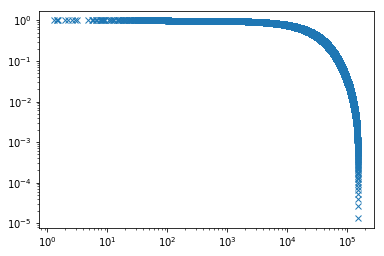

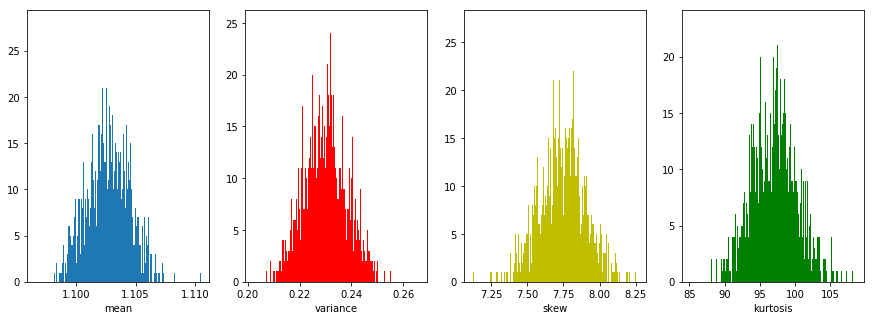

confidence interval for the mean:[1.0993 - 1.1061]
confidence interval for the variance:[0.2139 - 0.2461]
confidence interval for the skew:[7.4288 - 8.0468]
confidence interval for the kurtosis:[90.6183 - 103.5524]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Tail split at 2.01502642007926, alpha_value = 3.483457631985346


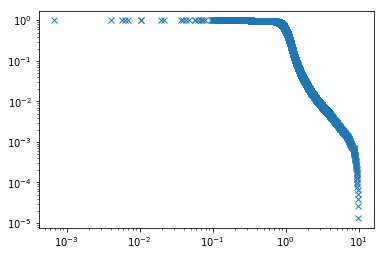

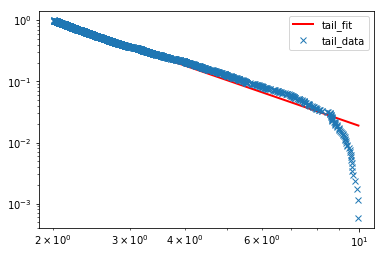

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [43]:
res=pipeline_(kill_death_without_outliers)

In [18]:
# it has a long tail because the data contains a lot of outliers
# so we have to remove them
# this is the function to remove the outliers and calculate the suitbale bin width
def del_outlier (col_of_df):
    q_25 = col_of_df.quantile(0.25)
    q_50 = col_of_df.quantile(0.5)
    q_75 = col_of_df.quantile(0.75)
    print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
    IQR = q_75-q_25
    print("IQR is: ",IQR)
   
    # removing outliers from the data: We only accept data smaller than Q3+3*IQR and larger than Q1-3*IQR
    profiles_without_outlier = col_of_df[np.logical_and(col_of_df <= q_75 + 3*IQR, col_of_df >= q_25 - 3*IQR)]
    
    # optimal width of bins is equal to: 2*IQR*n^(-1/3), n is the number of observations
    width = 2*IQR*np.power(len(profiles_without_outlier),-1/3)
    print("bin width is: ", width)
    
    return profiles_without_outlier, width

### Total time played confidence level

In [24]:
total_time=profiles["total_time_played"]
total_time.count()

75924

In [23]:
total_time_played_without_outlier, bins=del_outlier (total_time)

q_25 is:  652465.75 , q_50 is:  1489140.0 , q_75 is:  2785035.5
IQR is:  2132569.75
bin width is:  100979.016524


In [25]:
total_time_played_without_outlier1, bins1=del_outlier (total_time/60)
total_time_played_without_outlier1.max()

q_25 is:  10874.429166666667 , q_50 is:  24819.0 , q_75 is:  46417.25833333333
IQR is:  35542.82916666666
bin width is:  1682.98360873


153018.71666666667

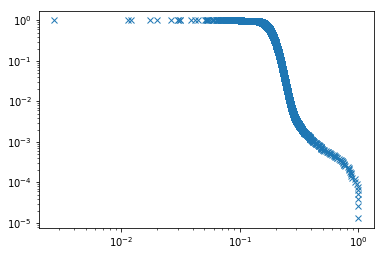

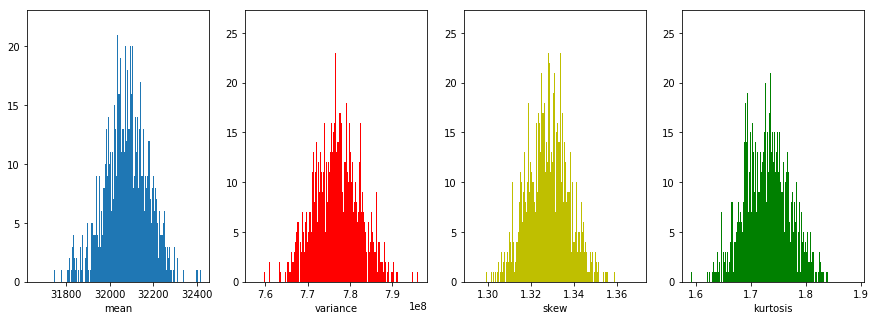

confidence interval for the mean:[31866.0012 - 32265.7652]
confidence interval for the variance:[766091498.8537 - 787827942.2346]
confidence interval for the skew:[1.3092 - 1.3464]
confidence interval for the kurtosis:[1.6508 - 1.8099]


Calculating best minimal value for power law fit


KeyboardInterrupt: 

In [42]:
res=pipeline_(total_time_played_without_outlier1)

### hit shot rate Confidence level

In [27]:
b=profiles.copy() 
b.loc[b['total_shots_fired'] ==0,'total_shots_fired']=1  

In [28]:
hit_fired = profiles["total_shots_hit"]/a["total_shots_fired"] 
hit_fired.head()



5     0.727273
8     0.176158
10    0.174500
11    0.107234
12    0.195682
dtype: float64

In [29]:
#hit_fired_without_outliers,binwidth = del_outlier (hit_fired)
hit_fired_without_outliers = hit_fired[hit_fired<1]

In [30]:
q_25 = hit_fired_without_outliers.quantile(0.25)
q_50 = hit_fired_without_outliers.quantile(0.5)
q_75 = hit_fired_without_outliers.quantile(0.75)
print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
IQR = q_75-q_25
print("IQR is: ",IQR)
hit_fired_without_outliers.min()

q_25 is:  0.16754585027759356 , q_50 is:  0.1845556539805461 , q_75 is:  0.202654709616771
IQR is:  0.035108859339177456


0.0

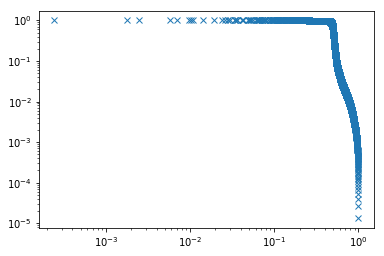

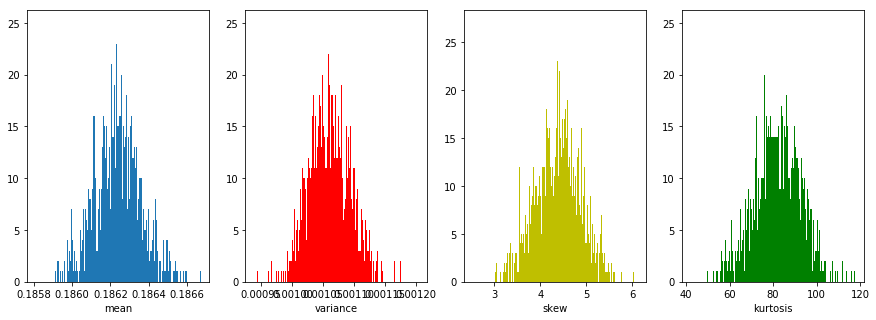

confidence interval for the mean:[0.1860 - 0.1865]
confidence interval for the variance:[0.0010 - 0.0011]
confidence interval for the skew:[3.4013 - 5.3371]
confidence interval for the kurtosis:[59.7971 - 103.0568]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


KeyboardInterrupt: 

In [41]:
res=pipeline_(hit_fired_without_outliers)

### winning Rate confidence level

In [34]:
c=profiles.copy() 
c.loc[c['total_rounds_played'] ==0,'total_rounds_played']=1  

In [35]:
((c["total_rounds_played"]==0)==True).sum()

0

In [36]:
win_rounds = profiles["total_wins"]/c["total_rounds_played"] # this is kill per second
win_rounds.head()



5     0.125000
8     0.507693
10    0.549020
11    0.550000
12    0.506329
dtype: float64

In [37]:
#win_rounds_without_outliers,binwidth = del_outlier (win_rounds)
win_rounds_without_outliers = win_rounds[win_rounds<1]

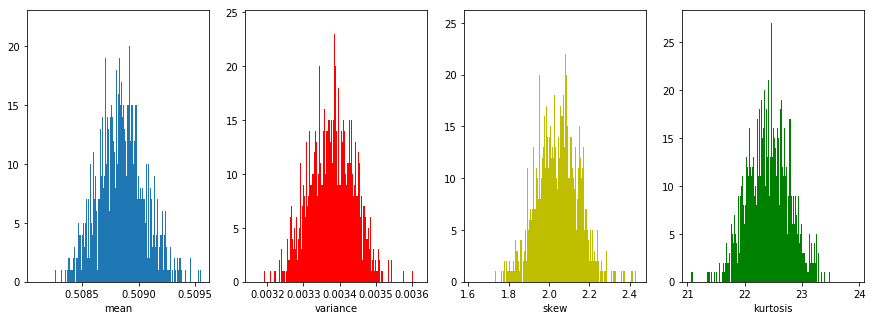

confidence interval for the mean:[0.5084 - 0.5093]
confidence interval for the variance:[0.0033 - 0.0035]
confidence interval for the skew:[1.8390 - 2.2567]
confidence interval for the kurtosis:[21.7193 - 23.1797]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


KeyboardInterrupt: 

In [40]:
res=pipeline_(win_rounds_without_outliers)

### Nick's code

In [0]:
head_shots_filt=cleaned_data.total_kills_headshot
head_shots_filt=head_shots_filt[head_shots_filt!= max(head_shots_filt)]

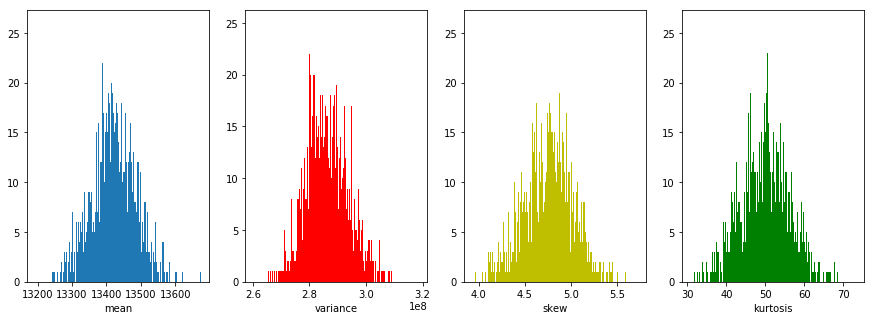

confidence interval for the mean:[13296.95 - 13542.87]
confidence interval for the variance:[272270341.54 - 301896289.03]
confidence interval for the skew:[  4.24 -   5.28]
confidence interval for the kurtosis:[ 37.26 -  62.15]


Calculating best minimal value for power law fit


Tail split at 76878.0, alpha_value = 4.20060513321088


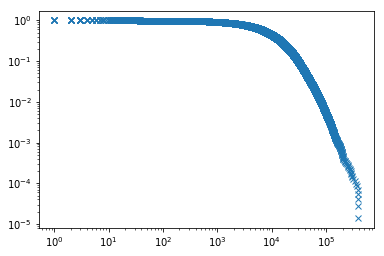

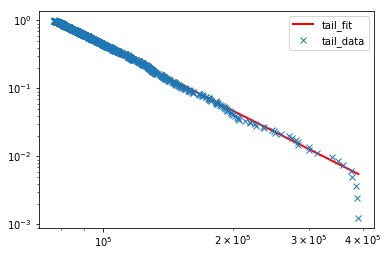

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [0]:
res=pipeline_(head_shots_filt)

In [0]:
res

(        dist                                              parms       loglik
 0      expon                               (1.0, 13420.9877912)       754628
 1       norm                     (13421.9874579, 16929.3181367)       801406
 2   logistic                     (10689.7508481, 7078.70440253)       784906
 3          t      (1.86561949545, 8100.53182625, 6625.75189318)       775834
 4       chi2              (0.00130103553024, 1.0, 4.5225621692)  1.07754e+08
 5   dweibull            (0.861397984736, 7090.0, 8950.79397007)       780012
 6       beta  (0.891640528092, 651.613500423, 1.0, 9819693.0...       754306
 7    lognorm                 (7.2991179942, 1.0, 10.4390426166)       874040
 8      gamma     (320.445578159, -483403.163576, 1547.47760038)       813235
 9   skewnorm      (707432924.669, 0.999863873502, 21603.561653)       769128
 10         f  (702179.927348, 4.02157741999, -3039.8932781, ...       756839
 11  powerlaw               (0.252987137826, 1.0, 403750.193364)

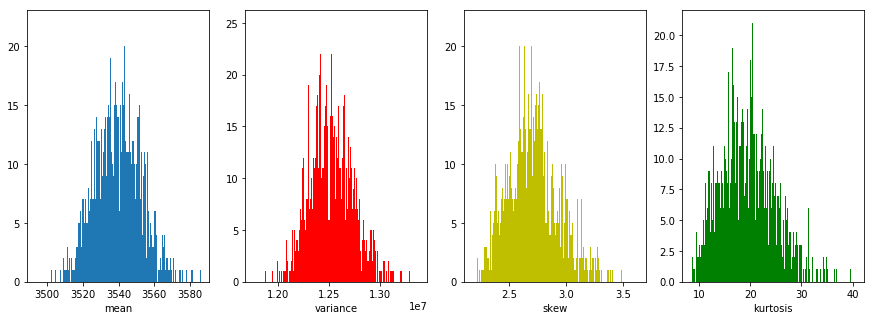

confidence interval for the mean:[3514.15 - 3565.85]
confidence interval for the variance:[12111600.82 - 12975223.40]
confidence interval for the skew:[  2.33 -   3.18]
confidence interval for the kurtosis:[ 10.64 -  30.96]


In [0]:
data=total_mvps
iteration = 5000

len_=len(data)
mean=[]
var=[]
skew=[]
kurto=[]

for i in range( iteration ):
    samp=np.random.choice(data,len_,replace=True)
    mean.append(np.mean(samp))
    var.append(np.var(samp))
    skew.append(stats.skew(samp))
    kurto.append(stats.kurtosis(samp))
figure,[a,b,c,d]=plt.subplots(1, 4,figsize=(15,5))
a.hist(mean,1000,label='mean')
a.set_xlabel("mean")
b.hist(var,1000,label='variance',color='r')
b.set_xlabel("variance")
c.hist(skew,1000,label='skew',color='y')
c.set_xlabel("skew")
d.hist(kurto,1000,label='kurtosis',color='g')
d.set_xlabel("kurtosis")
plt.show()
print("confidence interval for the mean:[%6.2f - %6.2f]" % (np.percentile(mean,2.5),np.percentile(mean,97.5)))
print("confidence interval for the variance:[%6.2f - %6.2f]" % (np.percentile(var,2.5),np.percentile(var,97.5)))
print("confidence interval for the skew:[%6.2f - %6.2f]" % (np.percentile(skew,2.5),np.percentile(skew,97.5)))
print("confidence interval for the kurtosis:[%6.2f - %6.2f]" % (np.percentile(kurto,2.5),np.percentile(kurto,97.5)))


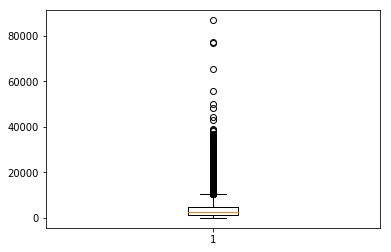

In [0]:
plt.boxplot(total_mvps)
plt.show()  # still some fake datas

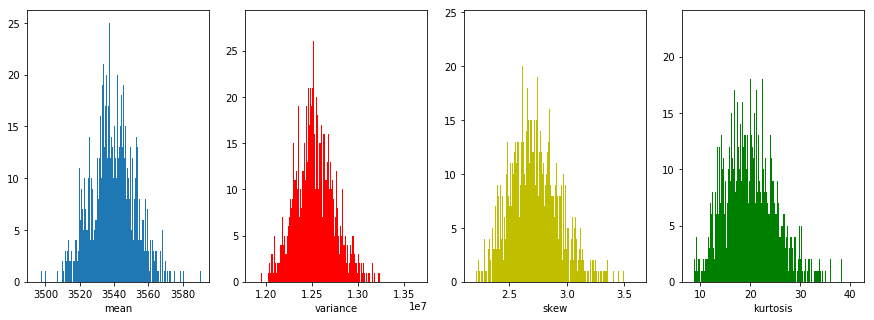

confidence interval for the mean:[3513.79 - 3565.50]
confidence interval for the variance:[12123083.49 - 12963858.48]
confidence interval for the skew:[  2.34 -   3.19]
confidence interval for the kurtosis:[ 10.95 -  31.23]


Calculating best minimal value for power law fit


Tail split at 18073.0, alpha_value = 5.734898987508731


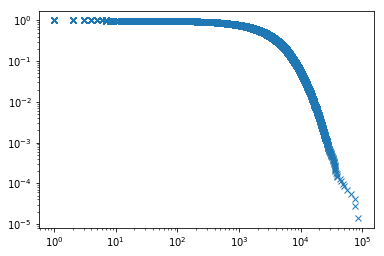

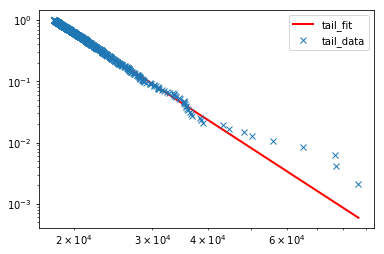

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(        dist                                              parms  loglik
 0      expon                    (0.999999999968, 3538.68150083)  658230
 1       norm                     (3539.68160348, 3539.38138825)  688311
 2   logistic                     (3019.86615218, 1727.47306361)  680639
 3          t       (2.76340522226, 2635.1339802, 2074.83202128)  677702
 4       chi2     (2866.53635858, -1337303.60291, 468.141397755)  818123
 5   dweibull      (1.02915052065, 2608.45578391, 2426.74728092)  679929
 6       beta  (1.01077115558, 784406.572265, 0.97367595046, ...  658226
 7    lognorm                (6.27614766846, 1.0, 8.40642380142)  771703
 8      gamma      (225.36882514, -45524.5371733, 217.691648545)  684660
 9   skewnorm     (245801934.959, 0.999900954465, 5004.91390844)  663431
 10         f  (2.15899481033, 69.2541210189, -11.3562041693,...  658400
 11  powerlaw               (0.266097686756, 1.0, 95117.0531482)  713320
 12    pareto     (0.14788147075, -1.41375115185, 2

In [0]:
#total_mvps=cleaned_data.total_mvps.dropna()
#total_mvps=total_mvps[total_mvps!= max(total_mvps)] # need to delete too extreme values again 
pipeline_(total_mvps)